<a href="https://colab.research.google.com/github/YasminGarcia1210/MAESTRIA_DATOS/blob/main/PARCIAL_1_FUNDAMENTOS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fundamento de Análitica 2

## Parcial #1

### Yasmin Johanna García

### El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos

In [253]:
#Importar librerias y recursos
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
!pip install fastai wwf bayesian-optimization -q --upgrade
from bayes_opt import BayesianOptimization
!pip install pmdarima
from pmdarima.arima import auto_arima
from pmdarima.utils import acf,pacf
from pmdarima.arima import ARIMA
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# 1. Carga y conocimiento de los datos

In [254]:
data = pd.read_csv("Examen.csv", index_col=0)
print(data.shape)
data.head(10)

(127, 2)


,producto1,producto2
1,4000.000000,3000.000000
2,3997.400893,3010.686220
3,3978.605317,3022.018584
4,3986.454125,3033.920990
5,3979.695678,3038.402098
6,3974.222492,3047.623815
7,3984.103665,3049.901717
8,3981.695269,3061.832340
9,3976.705402,3077.360465
10,3968.330510,3086.418917


# 2. Preprocesamiento de datos
* Convertir la columna 'mes' en un formato de fecha y establecerla como el índice del DataFrame.
* Si hay missing values, decidir si eliminarlos, imputarlos o utilizar técnicas de interpolación para manejarlos.
* Realizar transformaciones de datos si es necesario, como diferenciación para estacionarizar la serie temporal.

In [255]:
# Crear un índice de fecha y hora
dates = pd.date_range(start='2008-01-01', periods=len(data), freq='MS')
# Asignar el índice de fecha y hora a los datos
data.index = dates


# 3. Análisis exploratorio
* Visualizar las series temporales de ambos productos para comprender mejor sus características.
* Calcular estadísticas descriptivas como media, mediana, desviación estándar, etc.
* Identificar patrones de estacionalidad y tendencia.
Realizar pruebas de estacionariedad como la prueba de Dickey-Fuller aumentada.

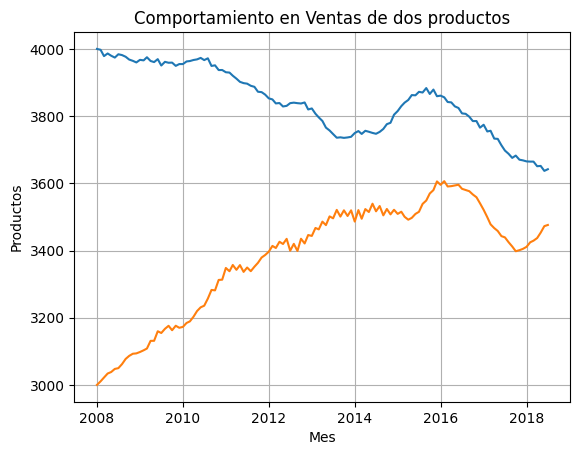

In [256]:
# Graficando los datos
plt.title("Comportamiento en Ventas de dos productos")
plt.xlabel("Mes")
plt.ylabel("Productos")
plt.plot(data[["producto1"]])
plt.plot(data[["producto2"]])
plt.grid()
plt.show()

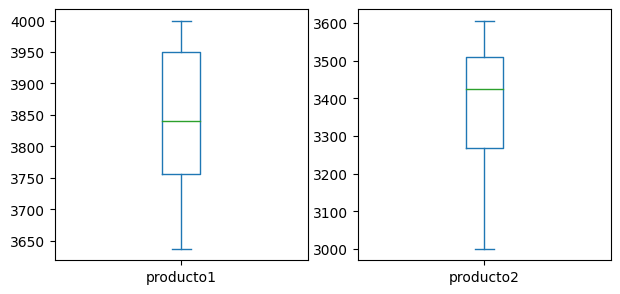

In [257]:
data.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False, figsize=(15,15))
plt.show()

In [258]:
#Analisis descriptivo
data.describe()

,producto1,producto2
count,127.000000,127.000000
mean,3843.571660,3381.037664
std,100.234821,167.504363
min,3637.047639,3000.000000
25%,3756.853812,3269.194001
50%,3840.644019,3426.048401
75%,3950.071775,3508.941718
max,4000.000000,3606.440615


# Descomponer la serie en sus componentes

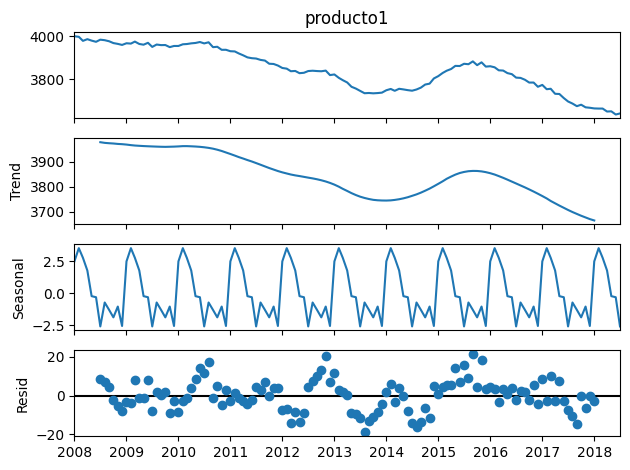

In [259]:
data = data.asfreq('MS')

# Descomponer la serie temporal de Producto 1
decomposition_producto1 = seasonal_decompose(data['producto1'], model='additive')

# Visualizar las componentes de la descomposición
decomposition_producto1.plot()
plt.show()

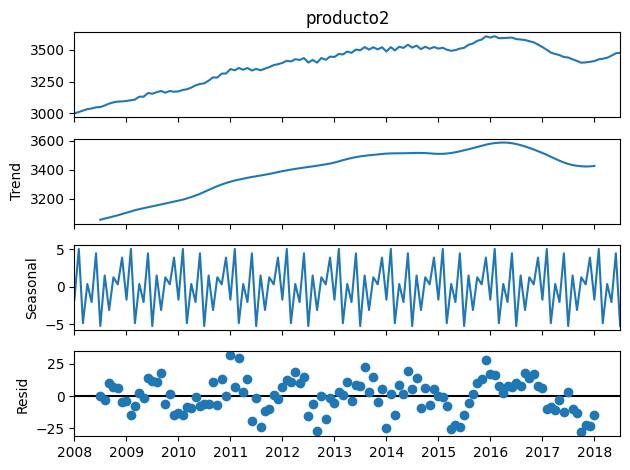

In [260]:
# Descomponer la serie temporal de Producto 2
decomposition_producto2 = seasonal_decompose(data['producto2'], model='additive')

# Visualizar las componentes de la descomposición
decomposition_producto2.plot()
plt.show()

## Qué podemos visualizar:

Al analizar los gráficos generados para los productos 1 y 2, se puede notar una tendencia no lineal en la distribución de los datos. Para el producto 1, la tendencia parece ser decreciente, mientras que para el producto 2, la tendencia parece ser creciente. Esto sugiere que hay variaciones significativas en la distribución de los datos para ambos productos a lo largo del conjunto de datos.

## 4. Modelado
Dividir los datos en conjuntos de entrenamiento y prueba.
Seleccionar el modelo adecuado para cada serie temporal (por ejemplo, ARIMA, SARIMA, modelos de suavizado exponencial, modelos de redes neuronales, etc.).
Ajustar los parámetros del modelo utilizando el conjunto de entrenamiento.
Validar el modelo utilizando el conjunto de prueba y evaluar su desempeño utilizando métricas como el error cuadrático medio (MSE), el error absoluto medio (MAE), etc.

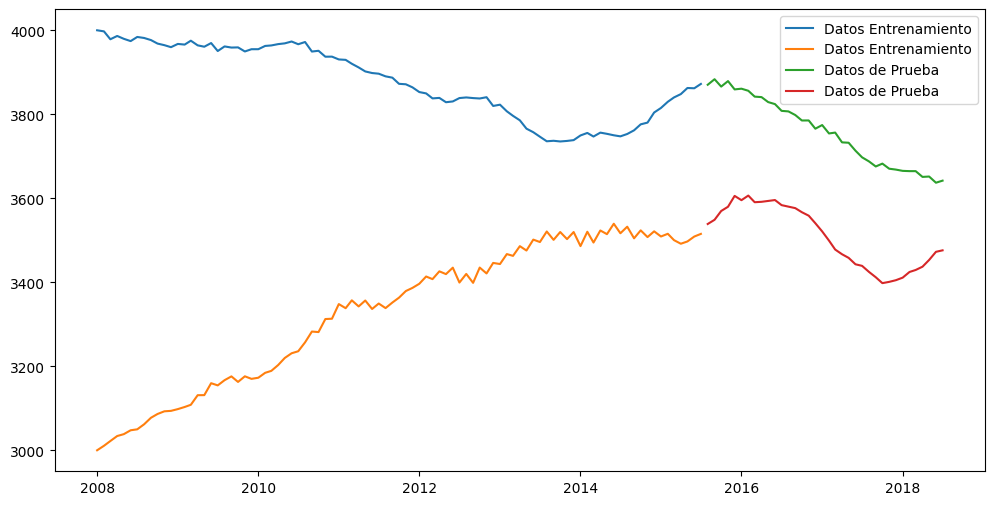

In [261]:
train_len = 91
train_td = data[:train_len]
test_td = data[train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [262]:
Resultados_columnas = ['Modelo', 'Configuración', 'RMSE', 'Coef R2']
Resultados = pd.DataFrame(columns=Resultados_columnas)

# Protocolo de Evaluación: Ventana Movil

5. Selección del mejor modelo
Comparar el desempeño de varios modelos utilizando métricas de evaluación.
Seleccionar el modelo que presente el mejor desempeño para cada serie temporal.

A continuación: se define una función llamada pto_evaluacion_arima que se encarga de entrenar un modelo ARIMA y devolver predicciones para luego calcular métricas de evaluación. Aquí hay una descripción de lo que hace cada parte del código:

La función toma cinco argumentos:

data: El conjunto de datos sobre el que se realizará el entrenamiento y la evaluación del modelo.
w: El tamaño de la ventana de entrenamiento, es decir, cuántas observaciones se utilizarán para entrenar el modelo en cada iteración.
h: El horizonte de predicción, es decir, cuántas observaciones en el futuro se van a predecir.
P, I, Q: Los parámetros del modelo ARIMA (orden de autorregresión, diferencia y media móvil).
Se inicializan listas vacías para almacenar las predicciones, los valores reales de prueba y los valores predichos.

Los bloques if verifican si los valores de P, I, y Q son None, en cuyo caso se establecen en 0 para evitar errores en el modelo ARIMA.

Se inicia un bucle for que itera sobre el rango de w. En cada iteración:

Se seleccionan los datos de entrenamiento y prueba correspondientes a la ventana actual.
Se crea un modelo ARIMA usando ARIMA del módulo statsmodels con los datos de entrenamiento y los parámetros dados.
El modelo se ajusta a los datos de entrenamiento usando fit.
Se realizan predicciones para una observación futura utilizando get_forecast.
Se extrae la predicción del objeto de pronóstico.
Las predicciones, los valores reales de prueba y los valores predichos se almacenan en las listas correspondientes.
Se calculan las métricas de evaluación, en este caso, el coeficiente de determinación (R2) y la raíz del error cuadrático medio (RMSE), utilizando las predicciones y los valores reales de prueba.



Se asignaron valores descriptivos a las variables relacionadas con los parámetros de entrada y los datos del producto 1 para mejorar la comprensión.
Los resultados de la función pto_evaluacion_arima se asignan a variables con nombres más descriptivos

In [263]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error

def pto_evaluacion_arima(data, w, h, P=1, I=1, Q=1):
    fore_all = []
    test_values = []
    fore_values = []

    # Ajustar los parámetros P, I, Q si son None
    if P is None:
        P = 0

    if I is None:
        I = 0

    if Q is None:
        Q = 0

    # Iterar sobre las ventanas móviles
    for i in range(w):
        train = data.iloc[i:(i + w + h)]
        test = data.iloc[i + w + h]

        # Entrenar el modelo ARIMA
        model = ARIMA(train, order=(P, I, Q))
        results = model.fit()

        # Realizar la predicción
        forecast = results.get_forecast(steps=1)
        fore = forecast.predicted_mean.values[0]

        # Almacenar los valores de predicción y de prueba
        fore_all.append(fore)
        test_values.append(test)
        fore_values.append(fore)

    # Calcular las métricas de evaluación
    r2 = r2_score(test_values, fore_values)
    rmse = np.sqrt(mean_squared_error(test_values, fore_values))

    return fore_all, rmse, r2


In [264]:
# prueba de Ventana Movil

# Obtener los resultados de la evaluación ARIMA
result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto1'], w=20, h=1, P=1, I=2, Q=1)

# Imprimir los resultados
print("Resultados de la evaluación ARIMA para el producto 1:")
print("Predicciones:", result_fore)
print("RMSE:", result_rmse)
print("Coeficiente R2:", result_r2)


Resultados de la evaluación ARIMA para el producto 1:
Predicciones: [3957.1151855301096, 3956.4905182403427, 3952.0321945943238, 3950.0186088734836, 3953.1761382910477, 3957.844827279714, 3963.923237091015, 3967.032729946467, 3969.3016223703144, 3973.0296559806093, 3970.7670858361007, 3969.841997622635, 3962.0559911847536, 3940.352580030571, 3934.427876750811, 3925.8705989952978, 3927.8330045559496, 3923.4159792979717, 3917.9619897323046, 3902.7186369354]
RMSE: 6.766273790439879
Coeficiente R2: 0.8878445559131165


Optimización bayesiana

In [265]:
def entrenar_arima(P, I, Q):
    data = pd.DataFrame({'producto1': np.random.rand(100)})  # Data de ejemplo
    w = 20
    h = 1
    result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto1'], w, h, int(P), int(I), int(Q))
    return -result_rmse

In [266]:
pbounds = {'P': (1, 3), 'I': (1, 3), 'Q': (1, 3)}

In [267]:
optimizer = BayesianOptimization(
    f=entrenar_arima,
    pbounds=pbounds,
    random_state=1234,
    verbose=2
)

In [268]:
optimizer.maximize(init_points=3, n_iter=50)
best_params = optimizer.max['params']
best_params['P'] = int(best_params['P'])
best_params['I'] = int(best_params['I'])
best_params['Q'] = int(best_params['Q'])


|   iter    |  target   |     I     |     P     |     Q     |
-------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

| 1         | -0.3729   | 1.383     | 2.244     | 1.875     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

| 2         | -0.3762   | 2.571     | 2.56      | 1.545     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

| 3         | -0.3503   | 1.553     | 2.604     | 2.916     |


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-inv

| 4         | -0.3979   | 2.562     | 2.404     | 2.839     |


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 5         | -0.3161   | 1.551     | 2.645     | 2.881     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 6         | -0.3551   | 1.535     | 2.632     | 2.837     |
| 7         | -0.2936   | 1.537     | 1.177     | 1.355     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 8         | -0.3044   | 1.336     | 1.803     | 1.192     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 9         | -0.2733   | 1.965     | 1.025     | 1.728     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: Us

| 10        | -0.4488   | 2.485     | 1.33      | 2.576     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 11        | -0.2836   | 2.0       | 1.045     | 1.777     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 12        | -0.405    | 2.251     | 1.458     | 2.341     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

| 13        | -0.3475   | 1.863     | 2.158     | 2.301     |
| 14        | -0.3157   | 1.986     | 1.123     | 1.746     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 15        | -0.4693   | 2.067     | 1.02      | 1.713     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 16        | -0.364    | 2.125     | 2.694     | 1.893     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 17        | -0.437    | 2.594     | 1.62      | 2.191     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

| 18        | -0.3541   | 1.956     | 2.252     | 1.564     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 19        | -0.2904   | 1.971     | 1.015     | 1.715     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 20        | -0.3468   | 1.508     | 1.171     | 1.102     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 21        | -0.3609   | 1.941     | 1.049     | 1.783     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

| 22        | -0.2743   | 1.947     | 2.246     | 1.557     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:60

| 23        | -0.3125   | 1.633     | 2.919     | 2.018     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 24        | -0.3204   | 1.921     | 1.801     | 1.024     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 25        | -0.2953   | 1.681     | 1.15      | 1.044     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 26        | -0.3649   | 1.256     | 1.736     | 1.113     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 27        | -0.314    | 1.525     | 1.189     | 1.355     |
| 28        | -0.3196   | 1.661     | 1.221     | 1.1       |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 29        | -0.4345   | 2.488     | 1.671     | 1.908     |


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 30        | -0.2857   | 1.94      | 2.245     | 1.559     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 31        | -0.3395   | 1.965     | 1.007     | 1.71      |


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


| 32        | -0.3351   | 1.531     | 1.182     | 1.331     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 33        | -0.3709   | 1.684     | 1.161     | 1.016     |
| 34        | -0.3244   | 1.662     | 1.145     | 1.029     |
| 35        | -0.3266   | 2.01      | 1.018     | 1.72      |
| 36        | -0.3389   | 1.981     | 1.023     | 1.707     |
| 37        | -0.3599   | 1.268     | 2.897     | 1.317     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/s

| 38        | -0.3121   | 1.65      | 2.897     | 2.025     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 39        | -0.296    | 1.69      | 1.128     | 1.054     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 40        | -0.3149   | 1.989     | 1.034     | 1.802     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

| 41        | -0.2398   | 2.07      | 2.205     | 1.94      |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 42        | -0.267    | 1.691     | 1.127     | 1.028     |
| 43        | -0.3401   | 1.984     | 1.006     | 1.753     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

| 44        | -0.4785   | 2.069     | 2.219     | 1.943     |


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning

| 45        | -0.4291   | 2.016     | 2.402     | 2.058     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

| 46        | -0.2659   | 1.522     | 1.193     | 1.346     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 47        | -0.3776   | 1.952     | 2.25      | 1.545     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 48        | -0.346    | 1.536     | 1.197     | 1.336     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/sta

| 49        | -0.4183   | 2.783     | 1.128     | 2.242     |
| 50        | -0.3098   | 1.98      | 1.058     | 1.753     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 51        | -0.3509   | 2.004     | 1.042     | 1.772     |


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


| 52        | -0.2778   | 2.25      | 2.148     | 1.845     |
| 53        | -0.3982   | 2.645     | 2.32      | 1.554     |


In [269]:
print(best_params)

{'I': 2, 'P': 2, 'Q': 1}


Se identifica los mejores conjuntos de parámetros encontrados por el optimizador y los almacena en una lista después de convertirlos a enteros si es necesario. Luego, imprime estos mejores conjuntos de parámetros

In [270]:
top_results = sorted(optimizer.res, key=lambda x: x['target'])[:5]
best_parameters_ = []
for i, res in enumerate(top_results):

    # Cast the best parameters to integers
    best_ = res['params']
    best_['P'] = int(best_['P'])
    best_['I'] = int(best_['I'])
    best_['Q'] = int(best_['Q'])
    best_parameters_.append(best_)

print(best_parameters_)

[{'I': 2, 'P': 2, 'Q': 1}, {'I': 2, 'P': 1, 'Q': 1}, {'I': 2, 'P': 1, 'Q': 2}, {'I': 2, 'P': 1, 'Q': 2}, {'I': 2, 'P': 1, 'Q': 1}]


In [271]:
# Lista para almacenar los resultados
resultados_lista = []

# Iterar sobre las mejores configuraciones
for i, best_params in enumerate(best_parameters_):
    # Obtener las métricas para cada configuración
    result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto1'], w=20, h=6, **best_params)

    # Agregar resultados a la lista
    resultados_lista.append({'Modelo': f'ARIMA {i+1}',
                             'Configuración': f"P={best_params['P']}, I={best_params['I']}, Q={best_params['Q']}",
                             'RMSE': result_rmse,
                             'Coef R2': result_r2})

# Concatenar la lista de resultados en un DataFrame
Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista)], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

In [272]:
Resultados

,Modelo,Configuración,RMSE,Coef R2
0,ARIMA 1,"P=2, I=2, Q=1",6.962039,0.951467
1,ARIMA 2,"P=1, I=2, Q=1",7.310917,0.946481
2,ARIMA 3,"P=1, I=2, Q=2",7.178734,0.948399
3,ARIMA 4,"P=1, I=2, Q=2",7.178734,0.948399
4,ARIMA 5,"P=1, I=2, Q=1",7.310917,0.946481


# Modelo ETS

Aquí está el desglose de lo que hace el siguiente  código:

Se definen las opciones para los diferentes componentes del modelo ETS, como error, tendencia y estacionalidad, como listas.
Se inicializan listas vacías para almacenar las predicciones, los valores de prueba y las predicciones de la función de pérdida.
Se itera sobre los datos, donde cada iteración corresponde a una ventana de tiempo de entrenamiento.
Se ajusta un modelo ETS a los datos de entrenamiento con los parámetros especificados.
Se utilizan los parámetros de suavizado especificados y se eliminan del diccionario de parámetros si los componentes de tendencia o estacionalidad son nulos.
Se realiza una predicción puntual para el siguiente paso de tiempo.
Se almacenan las predicciones, los valores de prueba y las predicciones de la función de pérdida en las listas correspondientes.
Finalmente, se calculan las métricas de evaluación, como el RMSE y el coeficiente R2, y se devuelven junto con las predicciones.

In [273]:
def pto_evaluacion_ets(data, w, h,error,trend,seasonal,alpha,beta,gamma):
    alpha = round(alpha,2)
    beta = round(beta,2)
    gamma = round(gamma,2)
    error1=["add","mul"]
    trend1=["add","mul",None]
    seasonal1=["add","mul",None]
    #print("error:",error1[round(error)])
    #print("trend:",trend1[round(trend)])
    #print("seasonal:",seasonal1[round(seasonal)])
    fore_all = []
    rmse_all = []
    test_values = []
    fore_values = []


    for i in range(w, len(data) - h + 1):
        train = data.iloc[i - w:i]
        test = data.iloc[i + h - 1]
        model = ETSModel(endog=train,
                        error=error1[round(error)],
                        trend=trend1[round(trend)],
                        seasonal=seasonal1[round(seasonal)])
        params = {'smoothing_level':alpha,
                 'smoothing_trend':beta,
                 'smoothing_seasonal':gamma}
        if trend1[round(trend)]==None:
            params.pop('smoothing_trend')
        if seasonal1[round(seasonal)]==None:
            params.pop('smoothing_seasonal')

        model_result = model.fit_constrained(params,initialization_method='estimated')

        point_forecast=model_result.forecast(1)

        fore_all.append(point_forecast)
        test_values.append(test)
        fore_values.append(point_forecast)

    r2 = r2_score(test_values, fore_values)
    rmse = np.sqrt(mean_squared_error(test_values, fore_values))

    return fore_all, rmse, r2

Este código esta utilizando una función llamada pto_evaluacion_ets para realizar la evaluación de un modelo ETS (Error-Trend-Seasonality) en los datos de la serie temporal del producto 1. Aquí hay una explicación de lo que hace este código:

Llama a la función pto_evaluacion_ets con los siguientes argumentos:

data['producto1']: Esto proporciona los datos de la serie temporal del producto 1.
w=124: Especifica el tamaño de la ventana de entrenamiento.
h=1: Indica el horizonte de predicción, es decir, cuántos pasos hacia adelante se desea predecir.
error=0, trend=1, seasonal=2: Estos argumentos controlan los componentes del modelo ETS (Error, Trend, Seasonal). Los valores específicos 0, 1 y 2 corresponden a diferentes opciones para cada componente del modelo, como se define en la función pto_evaluacion_ets.
alpha=0.01, beta=0.1, gamma=0.0001: Estos argumentos establecen los parámetros de suavizado para los componentes del modelo ETS (Alpha, Beta, Gamma), que son importantes para controlar la importancia relativa de las observaciones pasadas y los errores de predicción anteriores en el modelo.
Almacena los resultados de la función pto_evaluacion_ets en las variables result_fore, result_rmse y result_r2.

Imprime los resultados, incluyendo las predicciones, el RMSE (Root Mean Squared Error) y el coeficiente R2 (R-squared), que son métricas comunes para evaluar la calidad de las predicciones en modelos de series temporales.

In [274]:
result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto1'], w=124,h=1,
                                error= 0,
                                trend= 1,
                                seasonal= 2,
                                alpha =0.01,
                                beta = 0.1,
                                gamma = 0.0001)
        #error,trend,seasonal,alpha,beta,gamma
print ("Forecasts :",result_fore,
       "\n\nRMSE: ",result_rmse,
       "\n\nCoef. R2: ", result_r2)

Forecasts : [2018-05-01    3614.061776
Freq: MS, dtype: float64, 2018-06-01    3608.289408
Freq: MS, dtype: float64, 2018-07-01    3605.372202
Freq: MS, dtype: float64] 

RMSE:  34.59897059735758 

Coef. R2:  -30.90152125937359


/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: initialization_method. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: initialization_method. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed 

In [275]:
pbounds_ets = {'error': (0, 1),
           'trend': (0, 2),
           'seasonal': (2, 2), # mantendremos 2 dado que en la desc de datos no vimos estacionalidad
           'alpha': (0.01, 0.99),
           'beta': (0.01, 0.99),
           'gamma': (0.01, 0.99)
          }#data, w, h,error,trend,seasonal,alpha,beta,gamma

In [276]:
def entrenar_ets(error,trend,seasonal,alpha,beta,gamma):
    data = pd.DataFrame({'producto1': np.random.rand(100)})  # Data de ejemplo
    w = 20
    h =1
    result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto1'], w, h,error,trend,seasonal,alpha,beta,gamma)
    return -result_rmse

In [ ]:
entrenar_ets(1,2,2,0.01,0.1,0.01)

La optimización bayesiana es una técnica que busca encontrar la configuración óptima de hiperparámetros mediante la construcción de un modelo probabilístico de la función objetivo y la selección inteligente de puntos de evaluación. Se utiliza en situaciones donde la evaluación de la función objetivo es costosa o ruidosa, como en la optimización de hiperparámetros de modelos de aprendizaje automático, ya que busca explorar de manera eficiente el espacio de búsqueda y encontrar la mejor configuración con el menor número posible de evaluaciones

In [278]:
optimizerETS = BayesianOptimization(
    f=entrenar_ets,
    pbounds=pbounds_ets,
    random_state=1234,
    verbose=1
)

In [ ]:
optimizerETS.maximize(init_points=3, n_iter=10)
best_params = optimizerETS.max['params']

In [280]:
best_params

{'alpha': 0.8444386572842831,
 'beta': 0.9213702999507234,
 'error': 0.1994901659239724,
 'gamma': 0.47715336633067484,
 'seasonal': 2.0,
 'trend': 1.5911310317688414}

In [281]:
# Get the top 5 results
top_results = sorted(optimizerETS.res, key=lambda x: x['target'])[:5]
best_parameters_ = [
    {
        k: 'add' if k in ['seasonal', 'error', 'trend'] and int(v) == 0 else
           'mul' if k in ['seasonal', 'error', 'trend'] and int(v) == 1 else
           None if k in ['seasonal', 'error', 'trend'] and int(v) == 2 else v
        for k, v in res['params'].items()
    }
    for res in top_results
]

best_parameters = [
    {
        k: v
        for k, v in res['params'].items()
    }
    for res in top_results
]

In [ ]:
# Lista para almacenar los resultados
resultados_lista = []

# Iterar sobre las mejores configuraciones
for i, (best_par, homologated_par) in enumerate(zip(best_parameters, best_parameters_)):
    # Obtener las métricas para cada configuración
    result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto1'], w=20, h=6, **best_par)

    # Agregar resultados a otra lista (homologados)
    resultados_lista.append({
        'Modelo': f'Suavizacion ETS {i+1} ',
        'Configuración': f"({homologated_par['error']}, {homologated_par['trend']},{homologated_par['seasonal']}), a={round(homologated_par['alpha'],3)}, B={round(homologated_par['beta'],3)}, g={round(homologated_par['gamma'],3)}",
        'RMSE': result_rmse,
        'Coef R2': result_r2
    })

In [283]:
Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista)], ignore_index=True)
Resultados

,Modelo,Configuración,RMSE,Coef R2
0,ARIMA 1,"P=2, I=2, Q=1",6.962039,0.951467
1,ARIMA 2,"P=1, I=2, Q=1",7.310917,0.946481
2,ARIMA 3,"P=1, I=2, Q=2",7.178734,0.948399
3,ARIMA 4,"P=1, I=2, Q=2",7.178734,0.948399
4,ARIMA 5,"P=1, I=2, Q=1",7.310917,0.946481
5,Suavizacion ETS 1,"(add, add,None), a=0.198, B=0.62, g=0.78",37.196465,0.815718
6,Suavizacion ETS 2,"(add, mul,None), a=0.608, B=0.625, g=0.954",36.810392,0.819524
7,Suavizacion ETS 3,"(add, mul,None), a=0.281, B=0.796, g=0.868",36.661446,0.820982
8,Suavizacion ETS 4,"(add, add,None), a=0.096, B=0.481, g=0.881",38.034380,0.807322
9,Suavizacion ETS 5,"(add, mul,None), a=0.301, B=0.435, g=0.408",37.733879,0.810355


In [284]:
def train_and_predict_poly(data,w,h,grados):
    #y = train_data["Ocupados"]
    fore_all = []
    rmse_all = []
    test_values = []
    fore_values = []
    month_dummies = pd.get_dummies(data.index.month, drop_first=True).set_index(data.index)

    for i in range(w, len(data) - h + 1):
        train = data.iloc[i - w:i].copy()
        x = np.linspace(1, train.shape[0], train.shape[0])
        train["x"] = x
        train["x2"] = x**2
        #x_poly = np.column_stack([x**i for i in range(1, grados+1)])
        #print(train)
        test = pd.DataFrame(data.iloc[i + h - 1:i + h])
        train_dummy = month_dummies[i - w:i]
        test_dummy = month_dummies[i + h - 1:i + h]
        y = train['producto1'] # En este caso se asumirá que llega la columna seleccionada

        X = sm.add_constant(pd.concat([train[["x","x2"]],train_dummy],axis=1))

        model = sm.OLS(y, X)
        result = model.fit()

        x_for= np.linspace((train.shape[0]+1),(train.shape[0]+h),h) # generando x's para predecir
        x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] ) # Dataframe de los x
        range_dates = pd.date_range(train.index[-1] + relativedelta(months=1), periods=len(test), freq='MS')
        x_for_all.set_index(test.index, inplace=True)

        X_for = sm.add_constant(pd.concat([x_for_all, test_dummy], axis=1))
        X_for = pd.concat([pd.Series(1, index=x_for_all.index, name='const'), x_for_all, test_dummy], axis=1) # como add constant no sirvio, lo agregamos manual
        X_for.set_index(test.index, inplace=True)  # Set the index after adding the constant
        # Realizar predicciones
        predictions = result.get_prediction(X_for).summary_frame(alpha=0.05)
        y_prd = predictions['mean']

        # Crear el DataFrame de predicciones
        preds = pd.DataFrame(np.column_stack([y_prd]))
        preds.columns = ['Point_forecast']
        preds.set_index(range_dates, inplace=True)

        # Calcular métricas de rendimiento
        y_test = test['producto1']
        #print(preds,"<-pred\ntest->",y_test)
        y_test.index = range(len(y_test))
        test_values.append(y_test)
        fore_values.append(y_prd)

    #print(test_values)
    r2 = r2_score(test_values, fore_values)
    rmse = np.sqrt(mean_squared_error(test_values, fore_values))
    #print(f"Coeficiente R2 : {r2}")
    #print(f"RMSE : {rmse}")

    return fore_values,rmse,r2

In [285]:
# Lista para almacenar los resultados
resultados_lista = []

result_fore, result_rmse, result_r2 = train_and_predict_poly(data, w=124,h=1,grados=2)
print ("RMSE: ",result_rmse,
       "\nCoef. R2: ", result_r2)

    # Agregar resultados a otra lista (homologados)
resultados_lista.append({
        'Producto':'producto1','Modelo': f'Polinomica ',
        'Configuración': f"Grado 2",
        'RMSE': result_rmse,
        'Coef R2': result_r2
    })

RMSE:  73.8081896632991 
Coef. R2:  -144.17577212574247


In [286]:
Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista)], ignore_index=True)
Resultados

,Modelo,Configuración,RMSE,Coef R2,Producto
0,ARIMA 1,"P=2, I=2, Q=1",6.962039,0.951467,NaN
1,ARIMA 2,"P=1, I=2, Q=1",7.310917,0.946481,NaN
2,ARIMA 3,"P=1, I=2, Q=2",7.178734,0.948399,NaN
3,ARIMA 4,"P=1, I=2, Q=2",7.178734,0.948399,NaN
4,ARIMA 5,"P=1, I=2, Q=1",7.310917,0.946481,NaN
5,Suavizacion ETS 1,"(add, add,None), a=0.198, B=0.62, g=0.78",37.196465,0.815718,NaN
6,Suavizacion ETS 2,"(add, mul,None), a=0.608, B=0.625, g=0.954",36.810392,0.819524,NaN
7,Suavizacion ETS 3,"(add, mul,None), a=0.281, B=0.796, g=0.868",36.661446,0.820982,NaN
8,Suavizacion ETS 4,"(add, add,None), a=0.096, B=0.481, g=0.881",38.034380,0.807322,NaN
9,Suavizacion ETS 5,"(add, mul,None), a=0.301, B=0.435, g=0.408",37.733879,0.810355,NaN


# Hacemos el mismo analisis para el producto 2

In [287]:
#Prueba manual de ventana movil
result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto2'], w=20, h=1, P=1, I=2, Q=1)
print(result_rmse, result_r2)

11.833567296997256 0.9705284413657821


In [288]:
def entrenar_arima2(P, I, Q):
    data = pd.DataFrame({'producto2': np.random.rand(100)})  # Data de ejemplo
    w = 20
    h = 1
    result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto2'], w, h, int(P), int(I), int(Q))
    return -result_rmse

In [289]:
pbounds = {'P': (1, 3), 'I': (1, 3), 'Q': (1, 3)}

In [290]:
optimizer = BayesianOptimization(
    f=entrenar_arima,
    pbounds=pbounds,
    random_state=1234,
    verbose=2
)

In [ ]:
optimizer.maximize(init_points=3, n_iter=50)
best_params = optimizer.max['params']
best_params['P'] = int(best_params['P'])
best_params['I'] = int(best_params['I'])
best_params['Q'] = int(best_params['Q'])

In [292]:
best_params

{'I': 1, 'P': 1, 'Q': 1}

In [293]:
top_results = sorted(optimizer.res, key=lambda x: x['target'])[:5]
best_parameters_ = []
for i, res in enumerate(top_results):

    # Cast the best parameters to integers
    best_ = res['params']
    best_['P'] = int(best_['P'])
    best_['I'] = int(best_['I'])
    best_['Q'] = int(best_['Q'])
    best_parameters_.append(best_)

In [294]:
best_parameters_

[{'I': 2, 'P': 2, 'Q': 1},
 {'I': 1, 'P': 2, 'Q': 2},
 {'I': 2, 'P': 1, 'Q': 2},
 {'I': 2, 'P': 2, 'Q': 1},
 {'I': 2, 'P': 1, 'Q': 2}]

In [295]:
# Lista para almacenar los resultados
resultados_lista = []

# Iterar sobre las mejores configuraciones
for i, best_params in enumerate(best_parameters_):
    # Obtener las métricas para cada configuración
    result_fore, result_rmse, result_r2 = pto_evaluacion_arima(data['producto2'], w=20, h=6, **best_params)

    # Agregar resultados a la lista
    resultados_lista.append({'Producto':'producto2','Modelo': f'ARIMA {i+1}',
                             'Configuración': f"P={best_params['P']}, I={best_params['I']}, Q={best_params['Q']}",
                             'RMSE': result_rmse,
                             'Coef R2': result_r2})

# Concatenar la lista de resultados en un DataFrame
#Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista)], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [296]:
print(best_parameters_)

[{'I': 2, 'P': 2, 'Q': 1}, {'I': 1, 'P': 2, 'Q': 2}, {'I': 2, 'P': 1, 'Q': 2}, {'I': 2, 'P': 2, 'Q': 1}, {'I': 2, 'P': 1, 'Q': 2}]


In [297]:
# Concatenar la lista de resultados en un DataFrame
Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista)], ignore_index=True)
Resultados

,Modelo,Configuración,RMSE,Coef R2,Producto
0,ARIMA 1,"P=2, I=2, Q=1",6.962039,0.951467,NaN
1,ARIMA 2,"P=1, I=2, Q=1",7.310917,0.946481,NaN
2,ARIMA 3,"P=1, I=2, Q=2",7.178734,0.948399,NaN
3,ARIMA 4,"P=1, I=2, Q=2",7.178734,0.948399,NaN
4,ARIMA 5,"P=1, I=2, Q=1",7.310917,0.946481,NaN
5,Suavizacion ETS 1,"(add, add,None), a=0.198, B=0.62, g=0.78",37.196465,0.815718,NaN
6,Suavizacion ETS 2,"(add, mul,None), a=0.608, B=0.625, g=0.954",36.810392,0.819524,NaN
7,Suavizacion ETS 3,"(add, mul,None), a=0.281, B=0.796, g=0.868",36.661446,0.820982,NaN
8,Suavizacion ETS 4,"(add, add,None), a=0.096, B=0.481, g=0.881",38.034380,0.807322,NaN
9,Suavizacion ETS 5,"(add, mul,None), a=0.301, B=0.435, g=0.408",37.733879,0.810355,NaN


# Suavización

In [298]:
result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto2'], w=124,h=1,
                                error= 0,
                                trend= 1,
                                seasonal= 2,
                                alpha =0.01,
                                beta = 0.1,
                                gamma = 0.0001)
        #error,trend,seasonal,alpha,beta,gamma
print ("Forecasts :",result_fore,
       "\n\nRMSE: ",result_rmse,
       "\n\nCoef. R2: ", result_r2)

Forecasts : [2018-05-01    3449.572629
Freq: MS, dtype: float64, 2018-06-01    3463.452461
Freq: MS, dtype: float64, 2018-07-01    3459.64337
Freq: MS, dtype: float64] 

RMSE:  11.024974368661672 

Coef. R2:  -0.19909510950839993


/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: initialization_method. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: initialization_method. After release 0.14, this will raise.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed 

In [299]:
pbounds_ets2 = {'error': (0, 1),
           'trend': (0, 2),
           'seasonal': (2, 2), # mantendremos 2 dado que en la desc de datos no vimos estacionalidad
           'alpha': (0.01, 0.99),
           'beta': (0.01, 0.99),
           'gamma': (0.01, 0.99)
          }#data, w, h,error,trend,seasonal,alpha,beta,gamma

In [300]:
def entrenar_ets2(error,trend,seasonal,alpha,beta,gamma):
    data = pd.DataFrame({'producto2': np.random.rand(100)})  # Data de ejemplo
    w = 20
    h =1
    result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto2'], w, h,error,trend,seasonal,alpha,beta,gamma)
    return -result_rmse

In [301]:
optimizerETS = BayesianOptimization(
    f=entrenar_ets,
    pbounds=pbounds_ets2,
    random_state=1234,
    verbose=1
)

In [ ]:
optimizerETS.maximize(init_points=3, n_iter=50)
best_params = optimizerETS.max['params']

In [303]:
# Get the top 5 results
top_results = sorted(optimizerETS.res, key=lambda x: x['target'])[:5]
best_parameters_ = [
    {
        k: 'add' if k in ['seasonal', 'error', 'trend'] and int(v) == 0 else
           'mul' if k in ['seasonal', 'error', 'trend'] and int(v) == 1 else
           None if k in ['seasonal', 'error', 'trend'] and int(v) == 2 else v
        for k, v in res['params'].items()
    }
    for res in top_results
]

best_parameters = [
    {
        k: v
        for k, v in res['params'].items()
    }
    for res in top_results
]

In [ ]:
# Lista para almacenar los resultados
resultados_lista_ = []

# Iterar sobre las mejores configuraciones
for i, (best_par, homologated_par) in enumerate(zip(best_parameters, best_parameters_)):
    # Obtener las métricas para cada configuración
    result_fore, result_rmse, result_r2 = pto_evaluacion_ets(data['producto2'], w=20, h=6, **best_par)

    # Agregar resultados a otra lista (homologados)
    resultados_lista_.append({
        'Producto':'producto2','Modelo': f'Suavizacion ETS {i+1} ',
        'Configuración': f"({homologated_par['error']}, {homologated_par['trend']},{homologated_par['seasonal']}), a={round(homologated_par['alpha'],3)}, B={round(homologated_par['beta'],3)}, g={round(homologated_par['gamma'],3)}",
        'RMSE': result_rmse,
        'Coef R2': result_r2
    })

In [305]:
# Concatenar la lista de resultados en un DataFrame
Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista_)], ignore_index=True)
Resultados

,Modelo,Configuración,RMSE,Coef R2,Producto
0,ARIMA 1,"P=2, I=2, Q=1",6.962039,0.951467,NaN
1,ARIMA 2,"P=1, I=2, Q=1",7.310917,0.946481,NaN
2,ARIMA 3,"P=1, I=2, Q=2",7.178734,0.948399,NaN
3,ARIMA 4,"P=1, I=2, Q=2",7.178734,0.948399,NaN
4,ARIMA 5,"P=1, I=2, Q=1",7.310917,0.946481,NaN
5,Suavizacion ETS 1,"(add, add,None), a=0.198, B=0.62, g=0.78",37.196465,0.815718,NaN
6,Suavizacion ETS 2,"(add, mul,None), a=0.608, B=0.625, g=0.954",36.810392,0.819524,NaN
7,Suavizacion ETS 3,"(add, mul,None), a=0.281, B=0.796, g=0.868",36.661446,0.820982,NaN
8,Suavizacion ETS 4,"(add, add,None), a=0.096, B=0.481, g=0.881",38.034380,0.807322,NaN
9,Suavizacion ETS 5,"(add, mul,None), a=0.301, B=0.435, g=0.408",37.733879,0.810355,NaN


In [306]:
def train_and_predict_poly2(data,w,h,grados):
    #y = train_data["Ocupados"]
    fore_all = []
    rmse_all = []
    test_values = []
    fore_values = []
    month_dummies = pd.get_dummies(data.index.month, drop_first=True).set_index(data.index)

    for i in range(w, len(data) - h + 1):
        train = data.iloc[i - w:i].copy()
        x = np.linspace(1, train.shape[0], train.shape[0])
        train["x"] = x
        train["x2"] = x**2
        #x_poly = np.column_stack([x**i for i in range(1, grados+1)])
        #print(train)
        test = pd.DataFrame(data.iloc[i + h - 1:i + h])
        train_dummy = month_dummies[i - w:i]
        test_dummy = month_dummies[i + h - 1:i + h]
        y = train['producto2'] # En este caso se asumirá que llega la columna seleccionada

        X = sm.add_constant(pd.concat([train[["x","x2"]],train_dummy],axis=1))

        model = sm.OLS(y, X)
        result = model.fit()

        x_for= np.linspace((train.shape[0]+1),(train.shape[0]+h),h) # generando x's para predecir
        x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] ) # Dataframe de los x
        range_dates = pd.date_range(train.index[-1] + relativedelta(months=1), periods=len(test), freq='MS')
        x_for_all.set_index(test.index, inplace=True)

        X_for = sm.add_constant(pd.concat([x_for_all, test_dummy], axis=1))
        X_for = pd.concat([pd.Series(1, index=x_for_all.index, name='const'), x_for_all, test_dummy], axis=1) # como add constant no sirvio, lo agregamos manual
        X_for.set_index(test.index, inplace=True)  # Set the index after adding the constant
        # Realizar predicciones
        predictions = result.get_prediction(X_for).summary_frame(alpha=0.05)
        y_prd = predictions['mean']

        # Crear el DataFrame de predicciones
        preds = pd.DataFrame(np.column_stack([y_prd]))
        preds.columns = ['Point_forecast']
        preds.set_index(range_dates, inplace=True)

        # Calcular métricas de rendimiento
        y_test = test['producto2']
        #print(preds,"<-pred\ntest->",y_test)
        y_test.index = range(len(y_test))
        test_values.append(y_test)
        fore_values.append(y_prd)

    #print(test_values)
    r2 = r2_score(test_values, fore_values)
    rmse = np.sqrt(mean_squared_error(test_values, fore_values))
    #print(f"Coeficiente R2 : {r2}")
    #print(f"RMSE : {rmse}")

    return fore_values,rmse,r2
#PDTE subir version generica - correr prueba grado2

In [307]:
# Lista para almacenar los resultados
resultados_lista = []

result_fore, result_rmse, result_r2 = train_and_predict_poly2(data, w=20,h=1,grados=2)
print ("RMSE: ",result_rmse,
       "\nCoef. R2: ", result_r2)

    # Agregar resultados a otra lista (homologados)
resultados_lista.append({
        'Producto':'producto2','Modelo': f'Polinomica ',
        'Configuración': f"Grado 2",
        'RMSE': result_rmse,
        'Coef R2': result_r2
    })

RMSE:  23.792737684435608 
Coef. R2:  0.9562640418710611


In [308]:
# Concatenar la lista de resultados en un DataFrame
Resultados = pd.concat([Resultados, pd.DataFrame(resultados_lista)], ignore_index=True)
Resultados

,Modelo,Configuración,RMSE,Coef R2,Producto
0,ARIMA 1,"P=2, I=2, Q=1",6.962039,0.951467,NaN
1,ARIMA 2,"P=1, I=2, Q=1",7.310917,0.946481,NaN
2,ARIMA 3,"P=1, I=2, Q=2",7.178734,0.948399,NaN
3,ARIMA 4,"P=1, I=2, Q=2",7.178734,0.948399,NaN
4,ARIMA 5,"P=1, I=2, Q=1",7.310917,0.946481,NaN
5,Suavizacion ETS 1,"(add, add,None), a=0.198, B=0.62, g=0.78",37.196465,0.815718,NaN
6,Suavizacion ETS 2,"(add, mul,None), a=0.608, B=0.625, g=0.954",36.810392,0.819524,NaN
7,Suavizacion ETS 3,"(add, mul,None), a=0.281, B=0.796, g=0.868",36.661446,0.820982,NaN
8,Suavizacion ETS 4,"(add, add,None), a=0.096, B=0.481, g=0.881",38.034380,0.807322,NaN
9,Suavizacion ETS 5,"(add, mul,None), a=0.301, B=0.435, g=0.408",37.733879,0.810355,NaN
